In [19]:
import numpy as np
import xml.etree.ElementTree as et
from matplotlib import pyplot as plt
from matplotlib.patches import Arc
from matplotlib.axes import Axes
import pandas as pd
import requests
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import seaborn as sns

## Match Parser

In [20]:
# ---------------------------------------------------------------------------
""" 
Simple module to convert a xml file containing data in TRACAB format to a Match object
"""
# ---------------------------------------------------------------------------

class Match:
    def __init__(self, filePath):
        match = et.parse(filePath).getroot()[0]

        self.matchID      = int(match.attrib['id'])
        self.matchNr      = int(match.attrib['matchNumber'])
        self.date         = match.attrib['dateMatch']
        self.stadiumID    = int(match[1].attrib['id'])
        self.stadiumName  = match[1].attrib['name']
        self.pitchLength  = int(match[1].attrib['pitchLength'])
        self.pitchWidth   = int(match[1].attrib['pitchWidth'])
        self.phases       = [Phase(phase) for phase in match[2]]
        self.frames       = [Frame(frame) for frame in match[3]]
        
class Phase:
    def __init__(self, phase):
        self.start       = phase.attrib['start']
        self.end         = phase.attrib['end']
        self.leftTeamID  = int(phase.attrib['leftTeamID'])
        
class Frame:
    def __init__(self, frame):
        self.time            = frame.attrib['utc']
        self.ballInPlay      = frame.attrib['isBallInPlay']
        self.ballPossession  = frame.attrib['ballPossession']
        self.trackingObjs    = [TrackingObj(obj) for obj in frame[0]]
    
class TrackingObj:
    def __init__(self, obj):
        self.type      = obj.attrib['type']
        self.id        = obj.attrib['id']
        self.x         = int(obj.attrib['x'])
        self.y         = int(obj.attrib['y'])
        self.sampling  = obj.attrib['sampling']


## Draw Pitch

In [21]:
def draw_pitch(
    ax: Axes,
    x_min: float = -52.5,
    x_max: float = 52.5,
    y_min: float = 0,
    y_max: float = 68,
    zorder: int = -10,
):
    """Draw a football pitch on a given axes.

    The pitch is fitted between the given minimum and maximum coordinates.
    Scale is not guaranteed.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axes to draw the pitch on
    x_min : float, optional
        Minimum x point of the pitch, by default -52.5
    x_max : float, optional
        Maximum x point of the pitch, by default 52.5
    y_min : float, optional
        Minimum y point of the pitch, by default 0
    y_max : float, optional
        Maximum y point of the pitch, by default 68
    zorder : int, optional
        Plotting order of the pitch on the axes, by default -10
    """
    x = lambda x: (x / 130) * (x_max - x_min) + x_min
    y = lambda y: (y / 90) * (y_max - y_min) + y_min

    rat_x = (x_max - x_min) / 130
    rat_y = (y_max - y_min) / 90

    # Pitch Outline & Centre Line
    ax.plot([x(0), x(0)], [y(0), y(90)], color="black", zorder=zorder)
    ax.plot([x(0), x(130)], [y(90), y(90)], color="black", zorder=zorder)
    ax.plot([x(130), x(130)], [y(90), y(0)], color="black", zorder=zorder)
    ax.plot([x(130), x(0)], [y(0), y(0)], color="black", zorder=zorder)
    ax.plot([x(65), x(65)], [y(0), y(90)], color="black", zorder=zorder)

    # Left Penalty Area
    ax.plot([x(16.5), x(16.5)], [y(65), y(25)], color="black", zorder=zorder)
    ax.plot([x(0), x(16.5)], [y(65), y(65)], color="black", zorder=zorder)
    ax.plot([x(16.5), x(0)], [y(25), y(25)], color="black", zorder=zorder)

    # Right Penalty Area
    ax.plot([x(130), x(113.5)], [y(65), y(65)], color="black", zorder=zorder)
    ax.plot([x(113.5), x(113.5)], [y(65), y(25)], color="black", zorder=zorder)
    ax.plot([x(113.5), x(130)], [y(25), y(25)], color="black", zorder=zorder)

    # Left 6-yard Box
    ax.plot([x(0), x(5.5)], [y(54), y(54)], color="black", zorder=zorder)
    ax.plot([x(5.5), x(5.5)], [y(54), y(36)], color="black", zorder=zorder)
    ax.plot([x(5.5), x(0.5)], [y(36), y(36)], color="black", zorder=zorder)

    # Right 6-yard Box
    ax.plot([x(130), x(124.5)], [y(54), y(54)], color="black", zorder=zorder)
    ax.plot([x(124.5), x(124.5)], [y(54), y(36)], color="black", zorder=zorder)
    ax.plot([x(124.5), x(130)], [y(36), y(36)], color="black", zorder=zorder)

    # Prepare circles
    centre_circle = plt.Circle((x(65), y(45)), 9.15, color="black", fill=False, zorder=zorder)
    centre_spot = plt.Circle((x(65), y(45)), 0.8, color="black", zorder=zorder)
    left_pen_spot = plt.Circle((x(11), y(45)), 0.8, color="black", zorder=zorder)
    right_pen_spot = plt.Circle((x(119), y(45)), 0.8, color="black", zorder=zorder)

    # Draw Circles
    ax.add_patch(centre_circle)
    ax.add_patch(centre_spot)
    ax.add_patch(left_pen_spot)
    ax.add_patch(right_pen_spot)

    # Prepare Arcs
    left_arc = Arc(
        (x(11), y(45)),
        height=18.3 * rat_y,
        width=18.3 * rat_x,
        angle=0,
        theta1=310,
        theta2=50,
        color="black",
        zorder=zorder,
    )
    right_arc = Arc(
        (x(119), y(45)),
        height=18.3 * rat_y,
        width=18.3 * rat_x,
        angle=0,
        theta1=130,
        theta2=230,
        color="black",
        zorder=zorder,
    )

    # Draw Arcs
    ax.add_patch(left_arc)
    ax.add_patch(right_arc)


## Website Parser

In [22]:
# ---------------------------------------------------------------------------
""" 
Simple module to parse the UEFA website to get player id's, names, positions and stats
for a given team.
"""
# ---------------------------------------------------------------------------


baseURL = "https://www.uefa.com/uefaeuro-2020/teams/"

class Player:
    def __init__(self, attr):
        self.id             = attr[0]
        self.name           = attr[1]
        self.number         = attr[2]
        self.position       = attr[3]
        self.age            = attr[4]
        self.gamesPlayed    = attr[5]
        self.goals          = attr[6]
    
    def __str__(self):
        return("ID: {id}, Name: {nme}".format(id=self.id, nme=self.name))

def parseSite(teamID):
    teamURL = baseURL + str(teamID) + "/squad/"

    # Get the HTML from the site
    page = requests.get(teamURL)

    # Check for bad status code
    if not page.status_code == 200:
        print("Error: Could not get the page")
        return

    # Parse the HTML
    html = page.text
    soup = BeautifulSoup(html, 'html.parser')
    
    # The HTML has multiple divs with class 'squad--team-wrap' that contain all 
    # the player infos split by postition
    squad = soup.find_all('div', class_='squad--team-wrap')

    # Extract the player infos from the HTML
    players = []

    for wrap in squad[1:5]:
        postition = wrap.h5.text[:-1]

        for player in wrap.find('tbody').find_all('tr'):
            infos = player.find_all('td')

            players.append(Player([
                infos[0].find('a', class_='player-name')["href"].split("/")[-2].split("-")[0], 
                infos[0].find('a', class_='player-name')["title"], 
                infos[0].text.strip().split(" ")[-1].strip("()"), 
                postition, 
                infos[1].text.strip(), 
                infos[2].text.strip().replace("-", "0"), 
                infos[3].text.strip().replace("-", "0")
            ]))

    return players


## Utilities

In [23]:
def identify_half(start_times: list, end_times: list, timestamp):
    """
    Given a tz-UTC timestamp and two lists of tz-UTC timestamps
    for phase start and end times, return the half of the timestamp.

    Parameters
    ----------
    start_times: list
    end_times: list
    timestamp: pd.to_datetime("TZ-UTC") object

    Return
    ---------
    @return: returns the half number
    """

    if len(start_times) <= 2: # Match didn't go to extra time
        if start_times[0] <= timestamp and end_times[0] >= timestamp:
            return 1
        elif start_times[1] <= timestamp and end_times[1] >= timestamp:
            return 2
        else:
            return -1
    
    elif len(start_times) <= 4: # Match went to extra time
        if start_times[0] <= timestamp and end_times[0] >= timestamp:
            return 1
        elif start_times[1] <= timestamp and end_times[1] >= timestamp:
            return 2
        elif start_times[2] <= timestamp and end_times[2] >= timestamp:
            return 3
        elif start_times[3] <= timestamp and end_times[3] >= timestamp:
            return 4
        else:
            return -1


def get_location_velocity_acceleration(match, player_id, sampling_freq=25):

    """
    Given a parsed match object following @dcamenisch beautiful code, 
    player_id and a sampling frequency, first identify all of half numbers
    of the tracking objects, find the approximate m/s velocity, corresponding
    m/s**2 acceleration and location information of the player. Note that 
    TRACAB automatically mirrors the pitch for type="0" and type="1", the code is
    written so that the team always attacks to +5250 side on the x-axis.

    Parameters
    ----------
    match: Match object

    player_id: str
        player id as a string version 

    sampling_freq: int
        Sampling frequency in Hz, to jump between frames. Note that
        the data was collected in 25 Hz, so sf=25 means 1 second jumps.

    Returns
    ----------
    velo: list
        Velocity approximation, size should be one less than the location
    
    acc: list
        Acceleration approximation, size should be one less than the velocity

    location: list
        Locations, in meters. Attacking direction is always to right (x=+5250 goal)
    """
    phases = match.phases
    start_times = []
    end_times = []

    for phase in phases:
        start_times.append(pd.to_datetime(phase.start + "Z"))
        end_times.append(pd.to_datetime(phase.end + "Z"))
    
    if len(start_times) % 2 == 1: # If there are penalties, remove them, as they are irrelevant for velo/acc/location
        start_times = start_times[:-1]
        end_times = end_times[:-1]
    
    # Start times contain at most 4 items, first half, second half, et1, et2

    data = match.frames

    velo = []
    acc = []
    location = []
    loca_time_stamps = []
    velo_time_stamps = []

    number_of_frames = len(data)
    number_of_steps = int(number_of_frames/sampling_freq)

    for i in range(number_of_steps):
        frame = data[i*sampling_freq]
        objs = frame.trackingObjs

        for ob in objs:
            if ob.id == player_id:
                object_timestamp = pd.to_datetime(frame.time)
                half_number = identify_half(start_times=start_times, end_times=end_times, timestamp=object_timestamp)

                # Configure location to be always attacking to the left side for both teams
                # As coordinates are flipped in the tracking data, flip based on half and home team

                if (ob.type == "0" and (half_number == 1 or half_number == 3)) \
                    or (ob.type == "1" and (half_number == 2 or half_number == 4)): # If this is the case, append the location normally
                    location.append((-1*ob.x/100, -1*ob.y/100))
                    loca_time_stamps.append(object_timestamp)
                    if len(location) >= 2:
                        velo.append(np.sqrt((location[-1][0] - location[-2][0])**2 + \
                        (location[-1][1] - location[-2][1]) ** 2) / ((loca_time_stamps[-1] - loca_time_stamps[-2]).total_seconds()))
                        velo_time_stamps.append(loca_time_stamps[-1])
                    
                    if len(velo) > 1:
                        acc.append((velo[-1] - velo[-2])/((velo_time_stamps[-1] - velo_time_stamps[-2]).total_seconds()))
                
                elif (ob.type == "0" and (half_number == 2 or half_number == 4)) \
                    or (ob.type == "1" and (half_number == 1 or half_number == 3)): # If this is the case, append the location after multiplying with -1
                    location.append((ob.x/100, ob.y/100))
                    loca_time_stamps.append(object_timestamp)
                    if len(location) >= 2:
                        velo.append(np.sqrt((location[-1][0] - location[-2][0])**2 + \
                        (location[-1][1] - location[-2][1]) ** 2) / ((loca_time_stamps[-1] - loca_time_stamps[-2]).total_seconds()))
                        velo_time_stamps.append(loca_time_stamps[-1])
                    
                    if len(velo) > 1:
                        acc.append((velo[-1] - velo[-2])/((velo_time_stamps[-1] - velo_time_stamps[-2]).total_seconds()))

        
    return velo, acc, location

In [24]:
def find_running_mean(arr, window_size=60):
    """
    Given a velocity/acceleration array, and a window size, parse
    the array to return running means with a given window size. In 
    the examples that will be provided, we use 25 as sampling frequency,
    60 as the window size so that this returns 1 minute averages.

    Parameters
    ----------
    arr: list
        list of measurements to be averaged
    window_size: int (optional)
        number of measurements to be averaged, to yield a single average measurement.
    
    Returns
    ---------
    avg_velos:
        Don't mind the name :). Returns average measurements as a list.
    """

    avg_velos = []
    for i in range(int(len(arr)/window_size)):
        avg_velos.append(np.mean(arr[i*window_size:(i+1)*window_size]))
    
    return avg_velos


In [25]:
def plot_average_velocity_bestfit(arr, player_name):
    """
    Building upon running means, plot the minute-wise averages,
    fit a linear regression line on these.

    Parameters
    ----------
    arr: list
        list of average velocities

    player_name: str
        Player name the measurements have been taken.

    """
    x_values = np.linspace(0,len(arr)-1,len(arr)).reshape(-1,1)
    reg = LinearRegression()
    reg.fit(x_values, arr)
    preds = reg.predict(x_values)
    #plt.subplots(figsize=(10.5,6.8))
    plt.scatter(x_values, arr)
    plt.plot(x_values, preds, color="r")
    plt.title(player_name)
    plt.xlabel("Minutes Played")
    plt.ylabel("Average Velocity")
    return

In [26]:
def convert_location_plot(arr, offset=34):
    """
    Following @eakbiyik's excellent snippet on drawing a pitch
    using matplotlib, converts the location arrays returned in 
    get_location_velocity_acceleration and offsets the y-coordinates
    by 34 meters for better plotting. 
    """
    nparr = np.array(arr)
    nparr[:,1] += offset
    return nparr

In [27]:
def determine_player_location_clusters(location_arr, max_K = 5):
    """
    ! Note that this code is completely my own invention, I assume
    that there are obviously better implementations for this. !

    Takes a location array following get_location_velocity_acceleration
    and convert_location_plot, finds the best number of clusters with a 
    surrogate loss function. The minimum number is selected to be 2, to find
    at least two zones player was visiting the most frequently.

    Parameters
    ----------
    location_arr: list or np.array (recommend np.array)
        (n,2) dimensional array for player locations.
    
    max_K: int
        Maximal number of clusters to be taken.
    
    Returns
    ---------
    centers: np.array
        After finding the best number of clusters, fit once again and return
        the prototype vectors.
    labels: np.array
        n-dimensional array that labels the location samples
    """
    losses = []

    for i in range(2,max_K):
        cluster = KMeans(n_clusters=i)
        cluster.fit(location_arr)
        centers = cluster.cluster_centers_
        labels = cluster.labels_

        dummy_loss = 0
        for pt in range(len(location_arr)):
            point_label = labels[pt]
            center = centers[point_label]
            dummy_loss += np.sqrt((location_arr[pt][0] - center[0])**2 +\
                (location_arr[pt][1] - center[1])**2)
        
        #Surragate loss
        dummy_loss *= np.sqrt(i)
        losses.append(dummy_loss)
    
    
    k_ideal = np.argmin(losses) + 2
    cluster = KMeans(n_clusters=k_ideal)
    cluster.fit(location_arr)
    centers = cluster.cluster_centers_
    labels = cluster.labels_

    return centers, labels

In [28]:
def draw_position_clusters(centers, labels, player_name):
    """
    Following @eakbiyik's draw_pitch function and determine_player_location_clusters
    function, draw the pitch and clusters. Clusters are drawn as circles, radiuses of
    the circles are proportional to the number of member points.

    Parameters
    ----------
    centers:
        return 1 of determine player location clusters
    labels:
        return 2 of determine player location clusters
    player_name: str
        name of the player to set as title.

    """
    number_of_clusters = centers.shape[0]
    cluster_radius_coefficient = 10
    total_points = labels.shape[0]
    cluster_radius = []

    for i in range(number_of_clusters):
        points_in_cluster = np.where(labels == i)[0].shape[0]
        cluster_radius.append(cluster_radius_coefficient*points_in_cluster/total_points)

    fig, ax = plt.subplots(figsize=(10.5, 6.8))
    draw_pitch(ax)

    for i in range(number_of_clusters):
        cluster = plt.Circle(centers[i], radius=cluster_radius[i])
        ax.add_artist(cluster)
    
    plt.title(player_name)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    return

In [36]:
def get_player_name(id, team_1 = 66, team_2 = 122):
    """
    Following @dcamenisch's parseSite code, returns the player name
    given the team numbers from the site. In the example team_1 is 
    Italy and team_2 is Spain. You can check for your own team's id.
    
    """
    home_list = parseSite(team_1)
    for p in home_list:
        if p.id == id:
            return p.name
    
    away_list = parseSite(team_2)
    for p in  away_list:
        if p.id == id:
            return p.name

In [30]:
def draw_heatmap(array, player_name):
    """
    Following @ntittelbach's heatmap code, and the output of convert_location_plot,
    plot the heatmap of a player.

    Parameters
    ----------
    array: np.array
        return of the convert_location_plot

    player_name: str
        to add the player_name as the title to the heatmap.

    """
    fig, ax = plt.subplots(figsize=(10.5, 6.8))
    data = pd.DataFrame(array, columns=["long", "short"])
    sns.set_palette(sns.color_palette("flare"))
    sns.histplot(data, x="long", y="short", binwidth=(2.5, 2.0),  ax=ax, binrange=((-52.5, 52.5), (0, 68))).set(title = player_name)
    draw_pitch(ax, zorder=10)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    return

In [31]:
def get_team_unique_ids(match, type="0"):
    """
    Taking @dcamenisch match parser, get home or away teams unique player ids in a set
    Type="0" denotes home team, Type="1" denotes away team.
    """
    ids = set()
    for frame in match.frames:
        for obj in frame.trackingObjs:
            if obj.type == type:
                ids.add(obj.id)
    
    return list(ids)

In [32]:
def get_player_distance_covered(match, id):
    """
    Following @dcamenisch's match parser object, insert a player id
    to get the distance covered in meters.

    Parameters
    ----------
    match: match object parsed

    id: str
        player id in strings
    
    Returns
    ---------
    @return: float
        total distance covered for the player in meters.
    """
    x_c = []
    y_c = []
    num_frames = len(match.frames)
    for f in range(num_frames):
        for p in match.frames[f].trackingObjs:
            if((p.id) == id):
                x_c.append(int(p.x)/100)
                y_c.append(int(p.y)/100)

    x_c_nump = np.asarray(x_c)
    y_c_nump = np.asarray(y_c)
    return np.sum(np.sqrt(np.add(np.square(x_c_nump[1:] - x_c_nump[0:-1]), np.square(y_c_nump[1:] - y_c_nump[0:-1]))))

In [41]:
def do_clustering_best_fit_heatmap_for_player(match, player_id, home_team_num = 66, away_team_num = 122, average_velo_window_size=60, sample_freq=25, team_name="italy"):
    
    velo, _, location = get_location_velocity_acceleration(match=match, player_id=player_id, sampling_freq=sample_freq)
    dist_covered = get_player_distance_covered(match=match, id=player_id)
    player_name = get_player_name(id=player_id, team_1=home_team_num, team_2=away_team_num)
    avg_velos = find_running_mean(velo, window_size=average_velo_window_size)
    plotable_location = convert_location_plot(location)
    centers, labels = determine_player_location_clusters(location_arr=plotable_location)

    print("===============")
    print("Player Name: {}".format(player_name))
    print("Distance Covered: %.2f meters" % dist_covered)

    plt.figure()
    plot_average_velocity_bestfit(avg_velos, player_name)
    plt.savefig("plots/{tname}/bestfit/{pname}.png".format(tname=team_name, pname=player_name), bbox_inches="tight")
    plt.show()

    plt.figure()
    draw_position_clusters(centers=centers, labels=labels, player_name=player_name)
    plt.savefig("plots/{tname}/location/{pname}.png".format(tname=team_name, pname=player_name), bbox_inches="tight")
    plt.show()

    plt.figure()
    draw_heatmap(array=plotable_location, player_name=player_name)
    plt.savefig("plots/{tname}/heatmap/{pname}.png".format(tname=team_name, pname=player_name), bbox_inches="tight")
    plt.show()
    
    return

Player Name: Giovanni Di Lorenzo
Distance Covered: 14301.91 meters


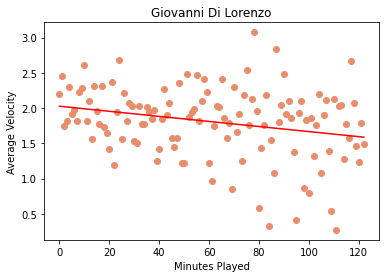

<Figure size 432x288 with 0 Axes>

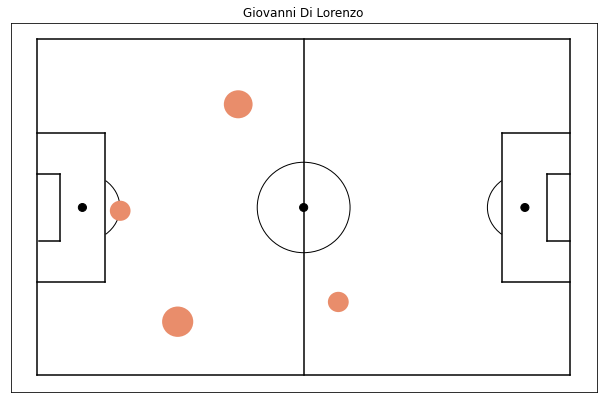

<Figure size 432x288 with 0 Axes>

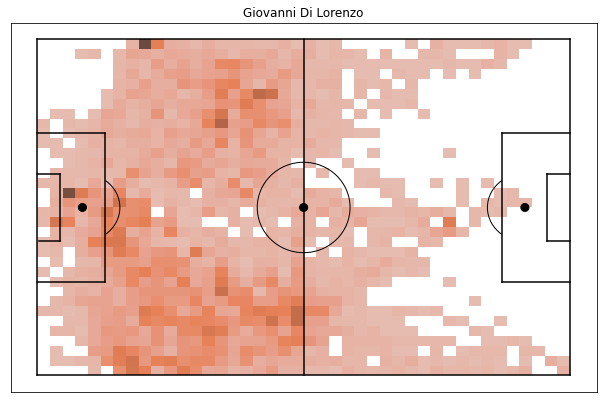

Player Name: Ciro Immobile
Distance Covered: 8529.71 meters


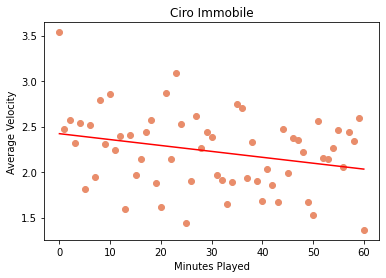

<Figure size 432x288 with 0 Axes>

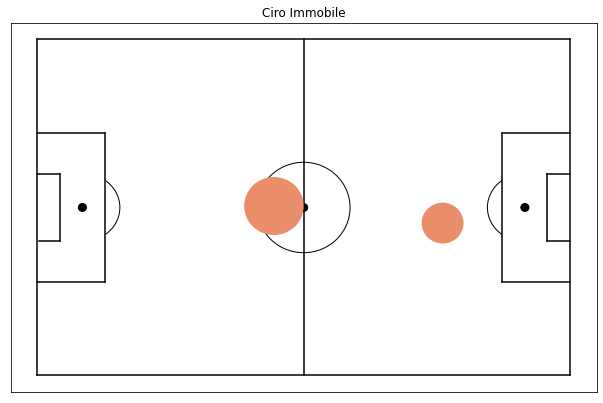

<Figure size 432x288 with 0 Axes>

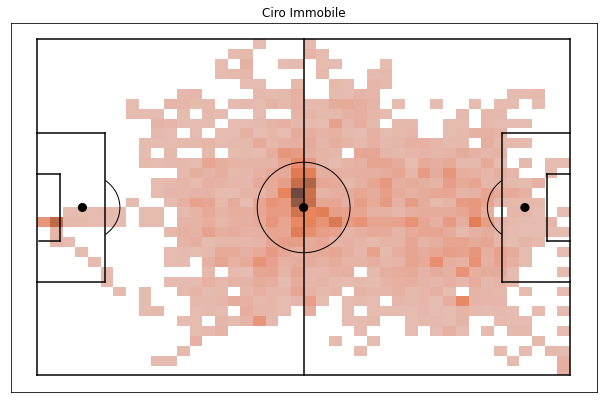

Player Name: Jorginho
Distance Covered: 15903.55 meters


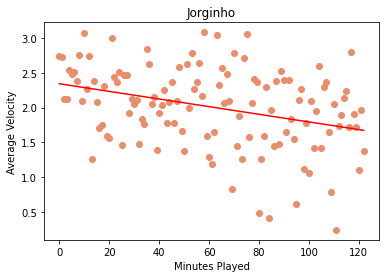

<Figure size 432x288 with 0 Axes>

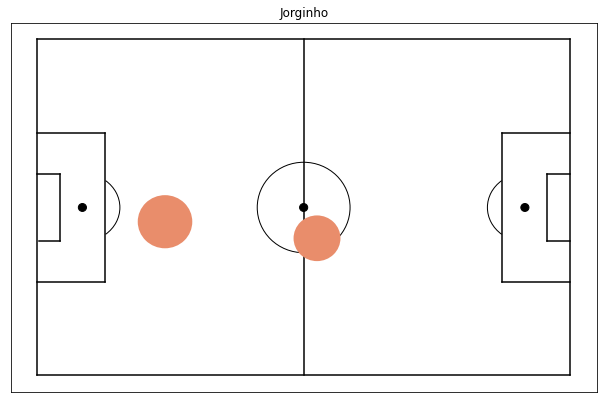

<Figure size 432x288 with 0 Axes>

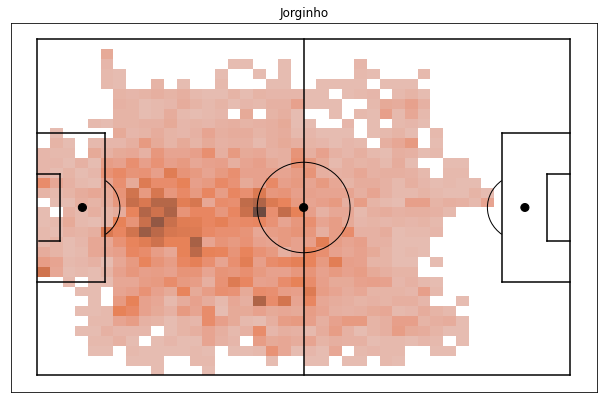

Player Name: Manuel Locatelli
Distance Covered: 5141.91 meters


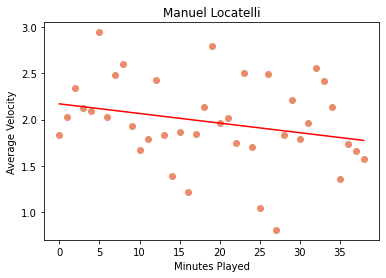

<Figure size 432x288 with 0 Axes>

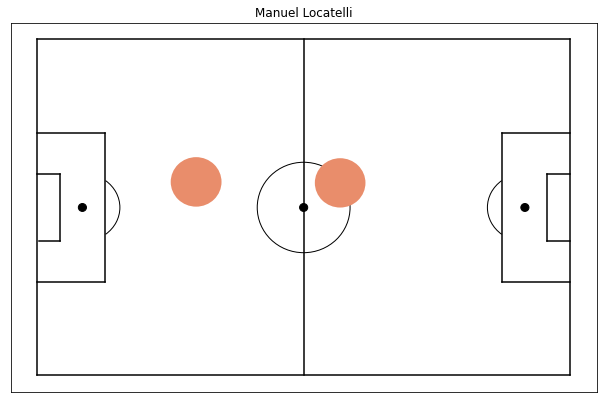

<Figure size 432x288 with 0 Axes>

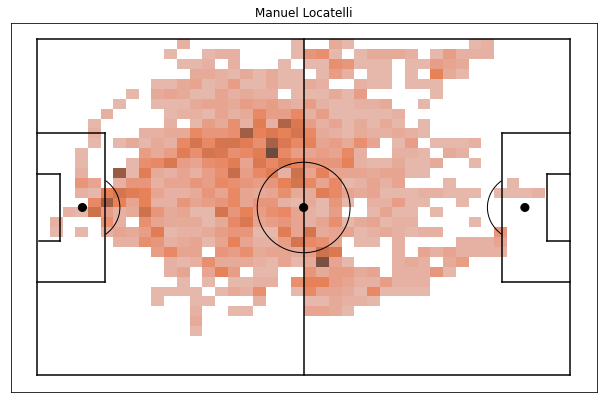

Player Name: Federico Bernardeschi
Distance Covered: 1790.81 meters


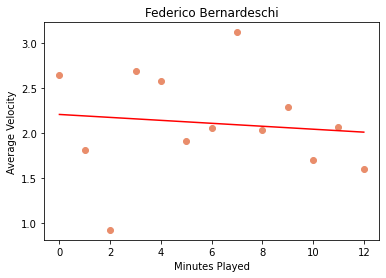

<Figure size 432x288 with 0 Axes>

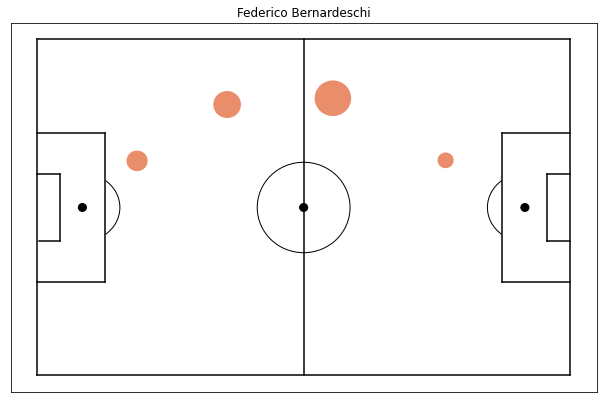

<Figure size 432x288 with 0 Axes>

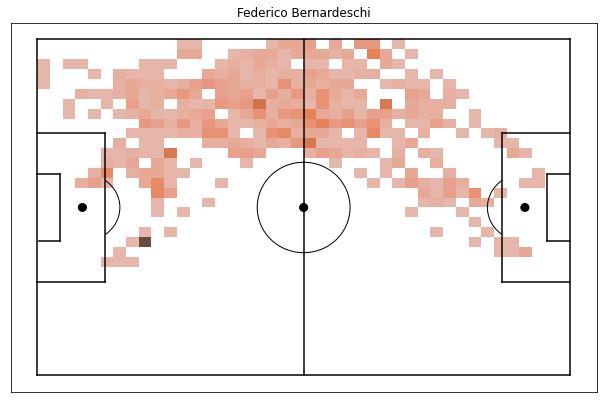

Player Name: Rafael Tolói
Distance Covered: 6149.59 meters


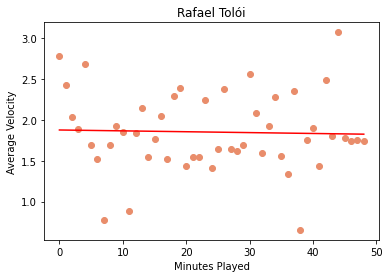

<Figure size 432x288 with 0 Axes>

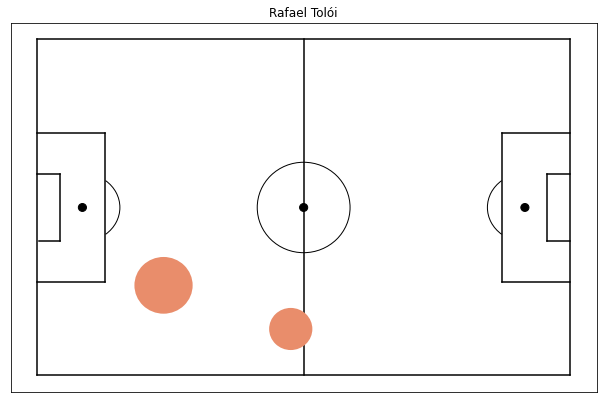

<Figure size 432x288 with 0 Axes>

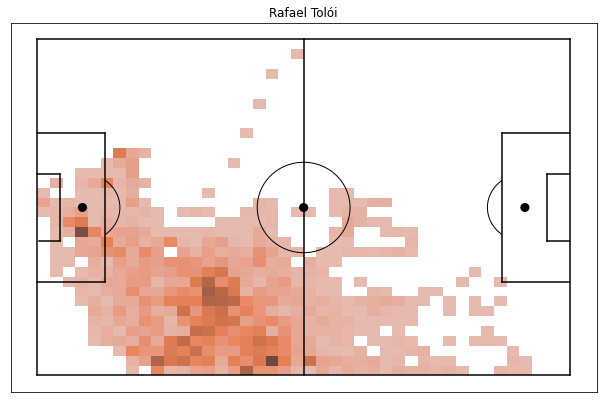

Player Name: Domenico Berardi
Distance Covered: 7529.74 meters


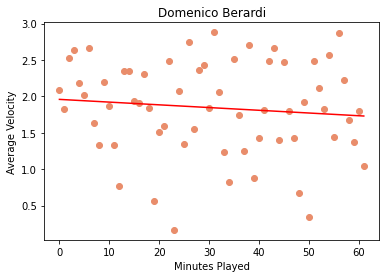

<Figure size 432x288 with 0 Axes>

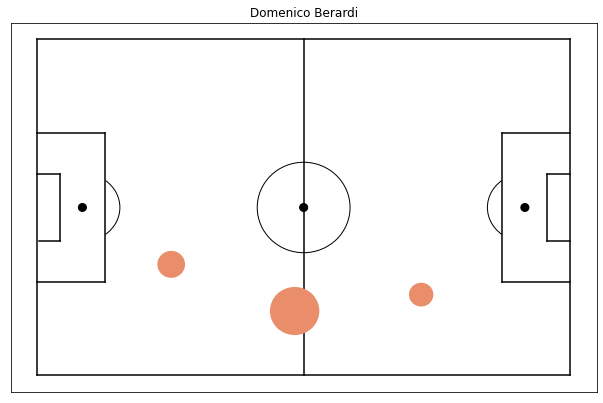

<Figure size 432x288 with 0 Axes>

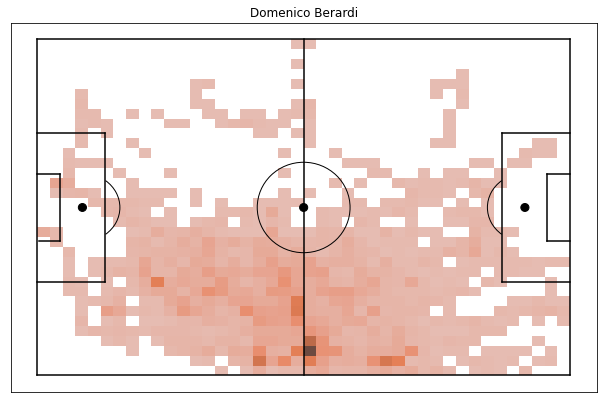

Player Name: Lorenzo Insigne
Distance Covered: 11008.55 meters


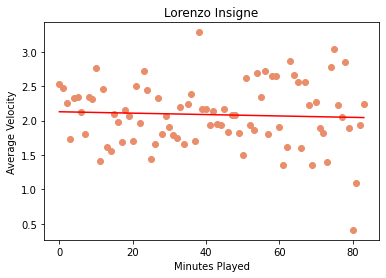

<Figure size 432x288 with 0 Axes>

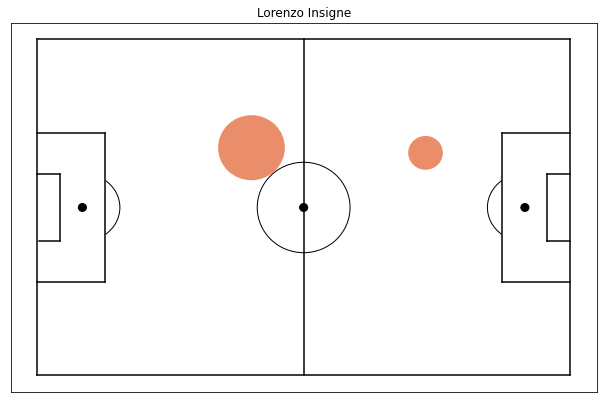

<Figure size 432x288 with 0 Axes>

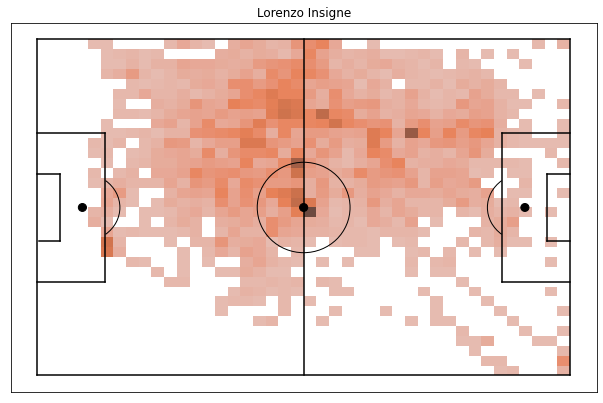

Player Name: Emerson
Distance Covered: 9119.49 meters


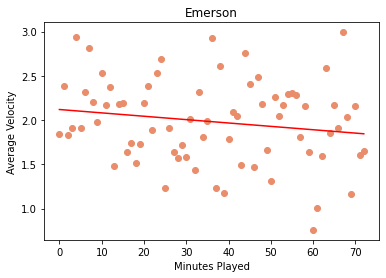

<Figure size 432x288 with 0 Axes>

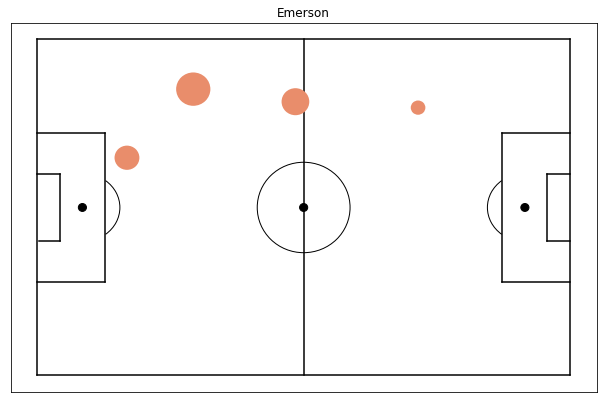

<Figure size 432x288 with 0 Axes>

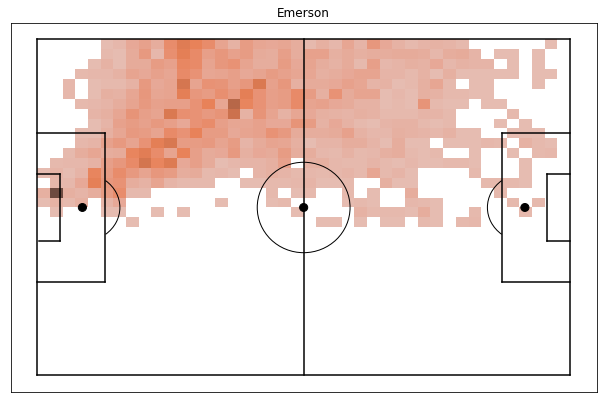

Player Name: Nicolò Barella
Distance Covered: 11329.57 meters


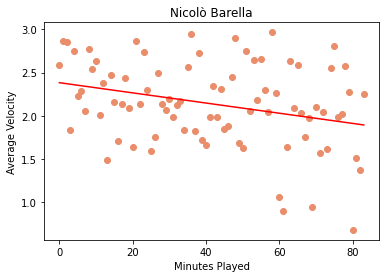

<Figure size 432x288 with 0 Axes>

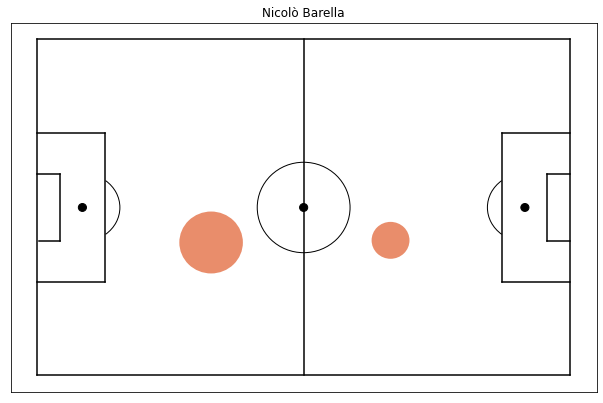

<Figure size 432x288 with 0 Axes>

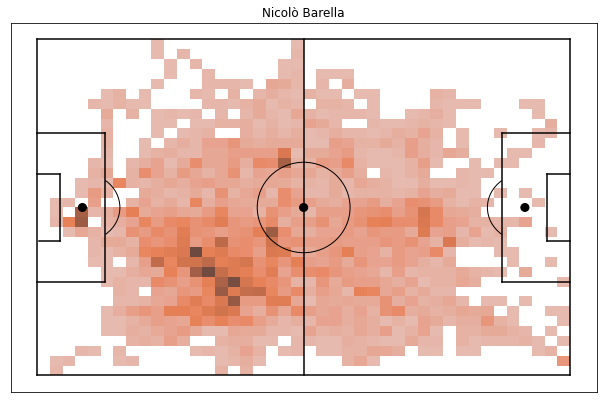

Player Name: Andrea Belotti
Distance Covered: 4941.58 meters


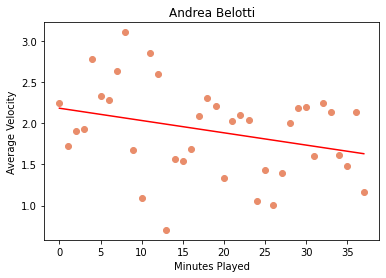

<Figure size 432x288 with 0 Axes>

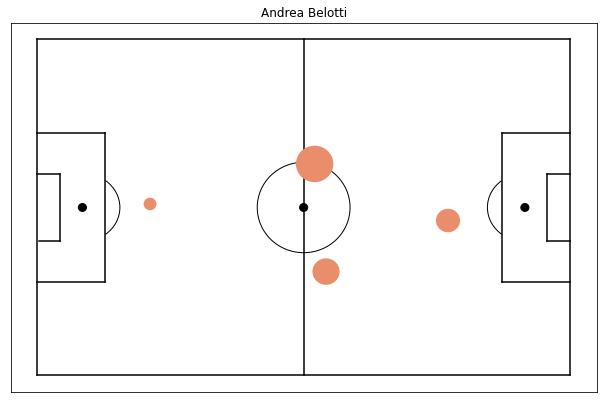

<Figure size 432x288 with 0 Axes>

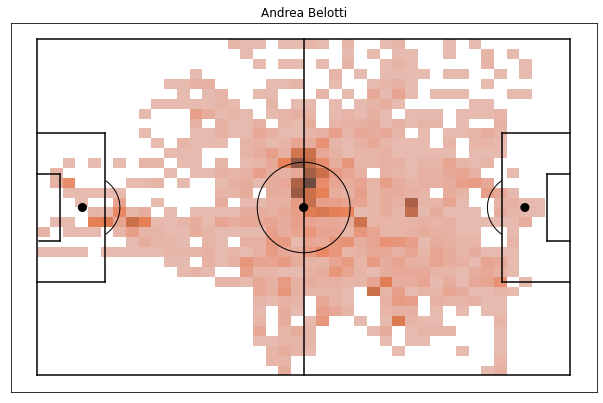

Player Name: Giorgio Chiellini
Distance Covered: 14138.41 meters


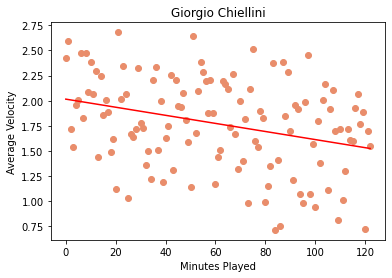

<Figure size 432x288 with 0 Axes>

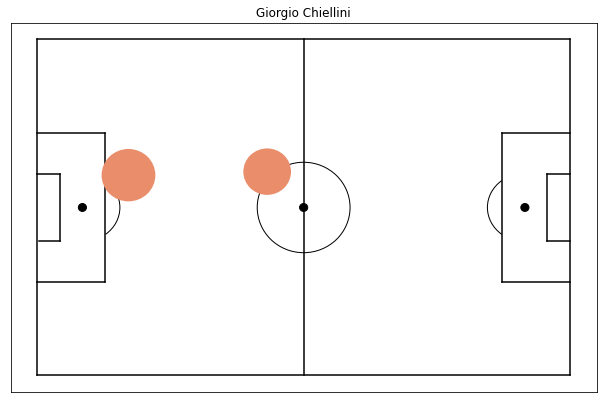

<Figure size 432x288 with 0 Axes>

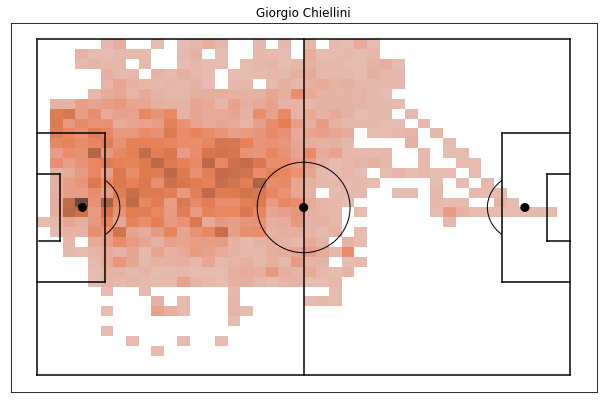

Player Name: Marco Verratti
Distance Covered: 10183.73 meters


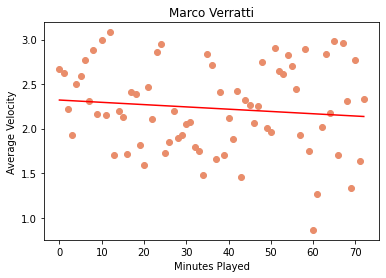

<Figure size 432x288 with 0 Axes>

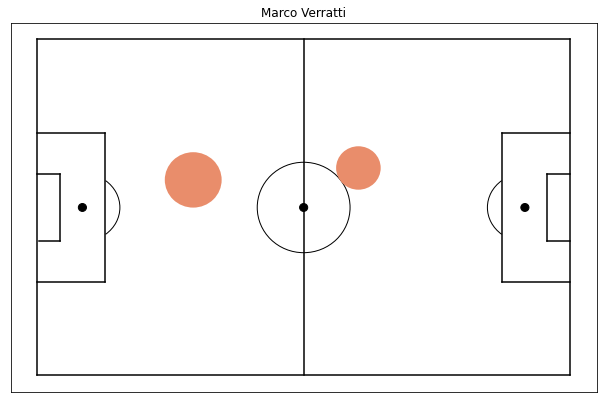

<Figure size 432x288 with 0 Axes>

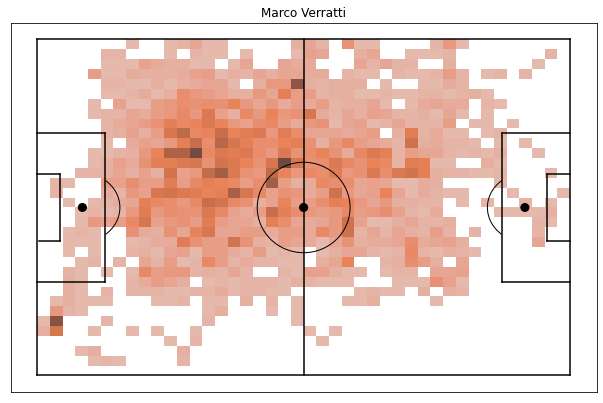

Player Name: Leonardo Bonucci
Distance Covered: 13252.63 meters


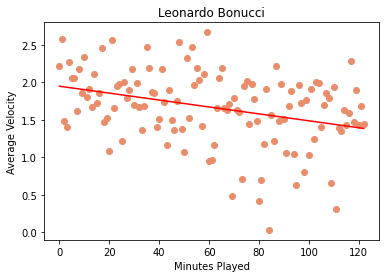

<Figure size 432x288 with 0 Axes>

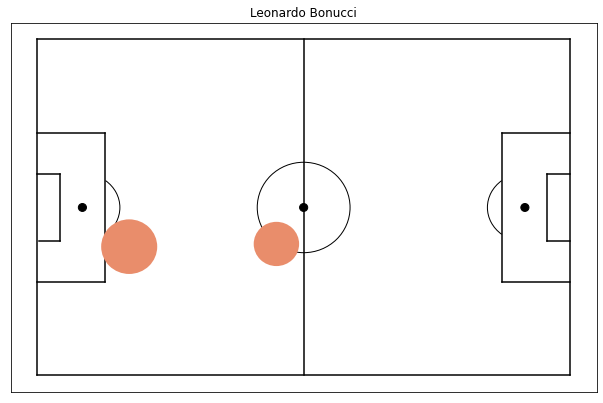

<Figure size 432x288 with 0 Axes>

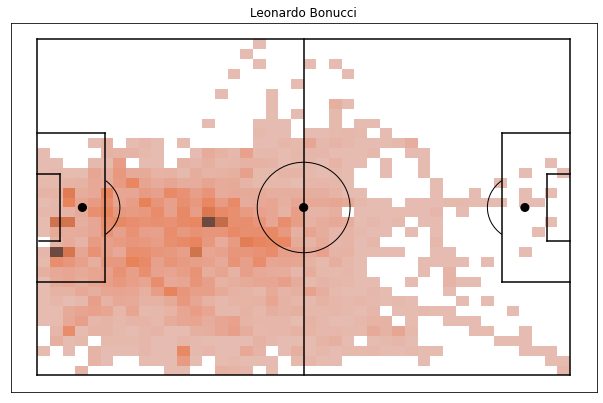

Player Name: Matteo Pessina
Distance Covered: 7168.10 meters


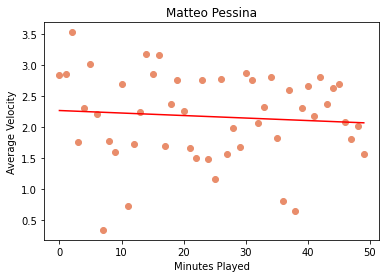

<Figure size 432x288 with 0 Axes>

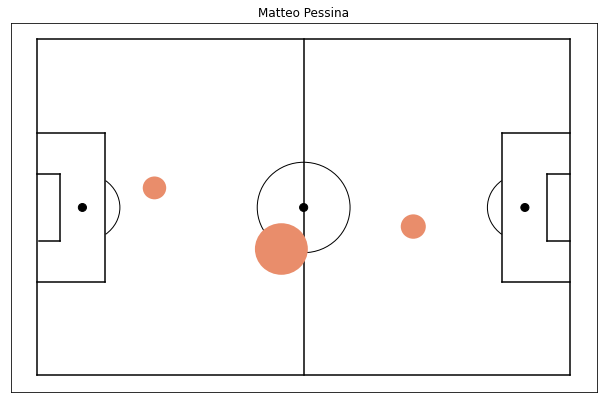

<Figure size 432x288 with 0 Axes>

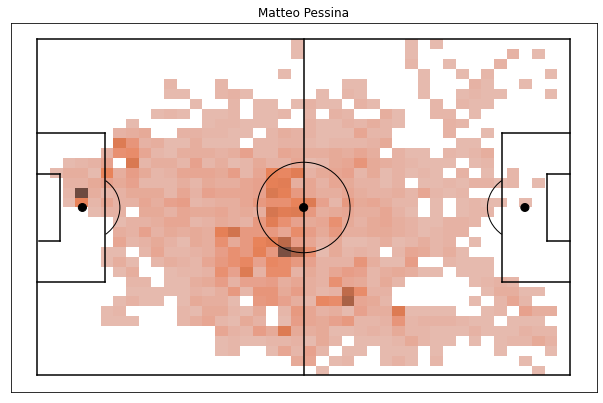

Player Name: Gianluigi Donnarumma
Distance Covered: 7773.73 meters


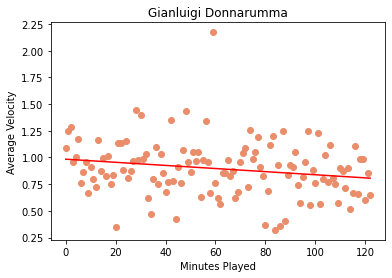

<Figure size 432x288 with 0 Axes>

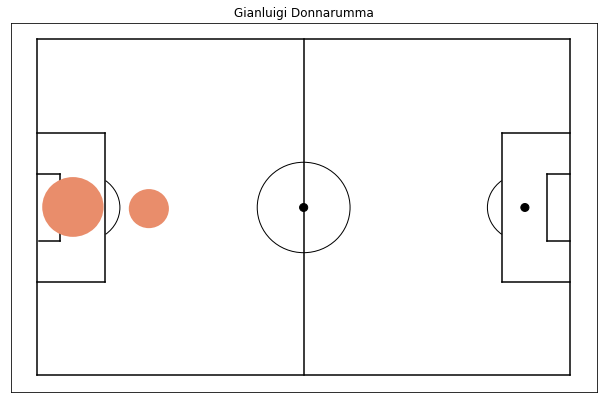

<Figure size 432x288 with 0 Axes>

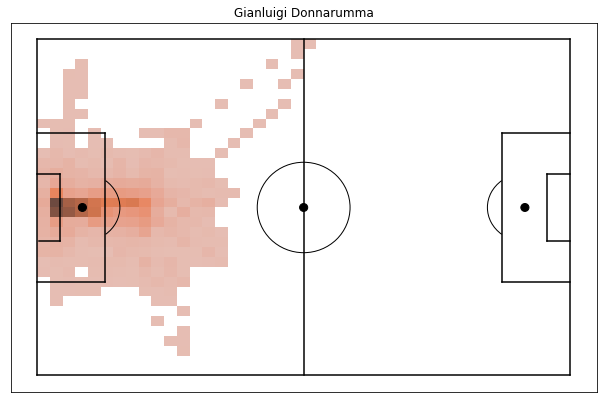

Player Name: Federico Chiesa
Distance Covered: 12598.88 meters


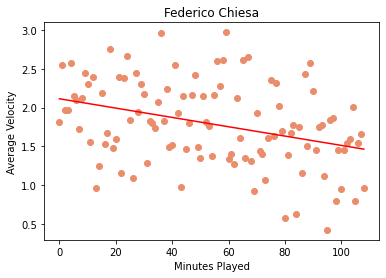

<Figure size 432x288 with 0 Axes>

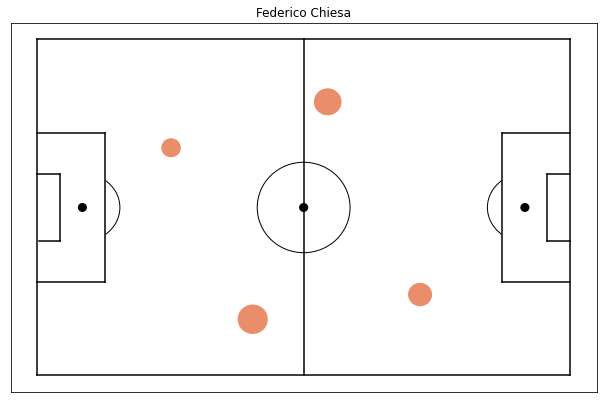

<Figure size 432x288 with 0 Axes>

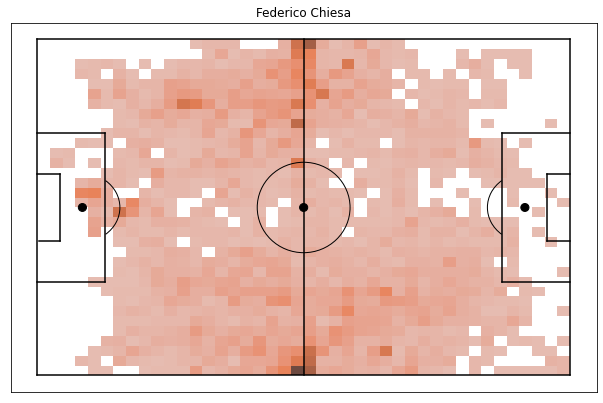

In [42]:
match = Match("data/Italy v Spain.xml")
home_ids = get_team_unique_ids(match, "0")
away_ids = get_team_unique_ids(match, "1")

for id in home_ids:
    do_clustering_best_fit_heatmap_for_player(match, id)


Player Name: Rodri
Distance Covered: 7232.78 meters


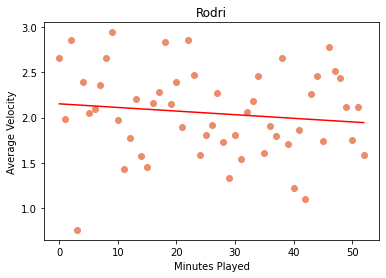

<Figure size 432x288 with 0 Axes>

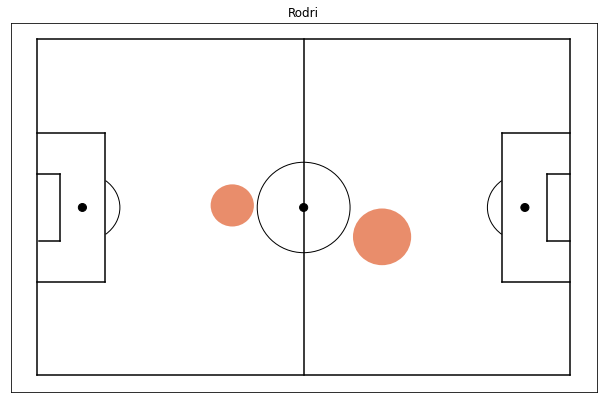

<Figure size 432x288 with 0 Axes>

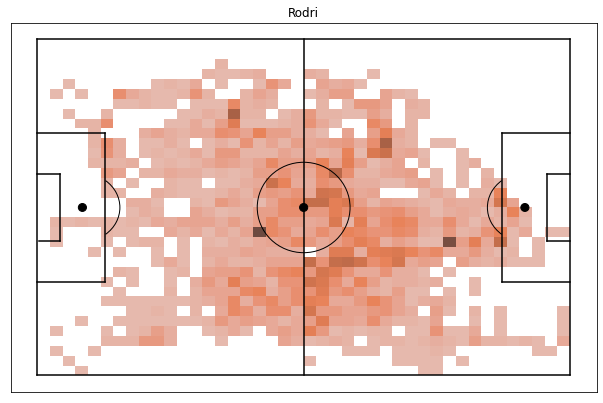

Player Name: Aymeric Laporte
Distance Covered: 14105.99 meters


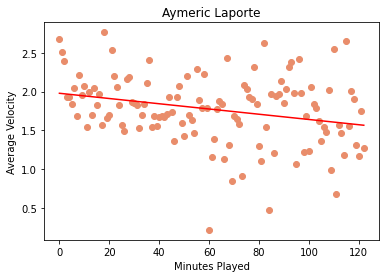

<Figure size 432x288 with 0 Axes>

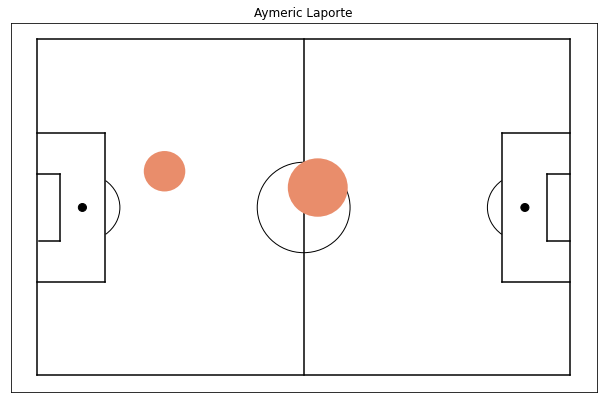

<Figure size 432x288 with 0 Axes>

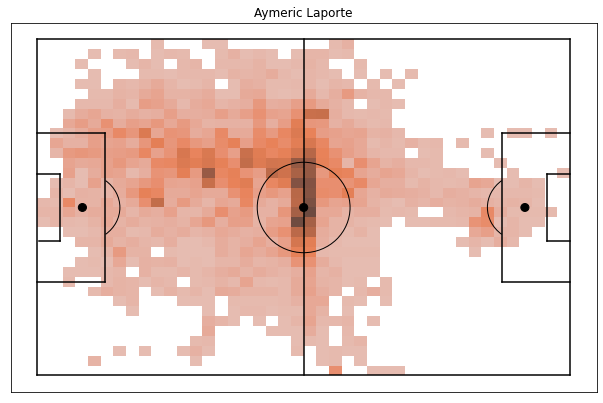

Player Name: Álvaro Morata
Distance Covered: 7723.73 meters


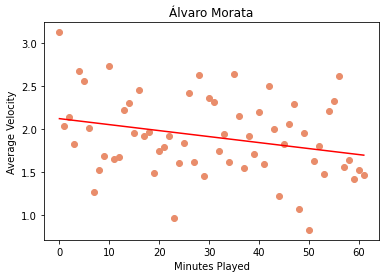

<Figure size 432x288 with 0 Axes>

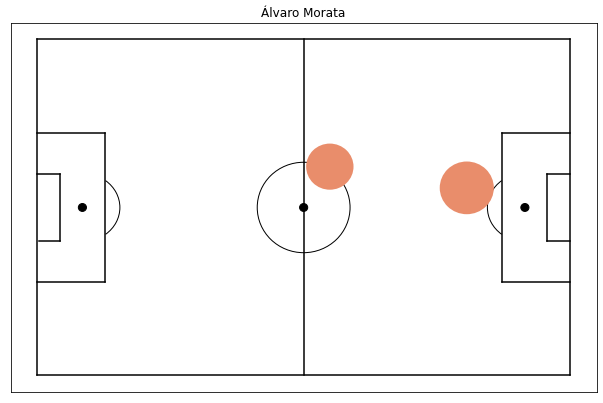

<Figure size 432x288 with 0 Axes>

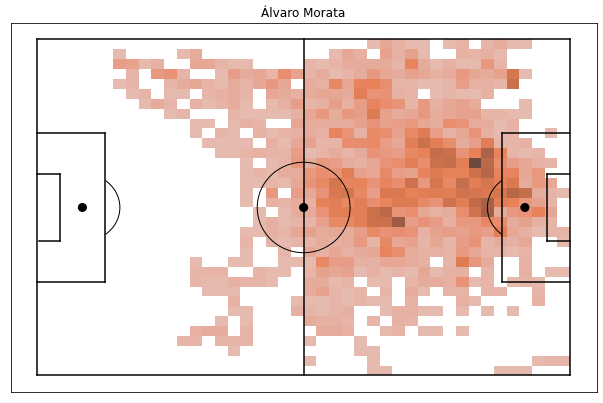

Player Name: Pedri
Distance Covered: 15865.44 meters


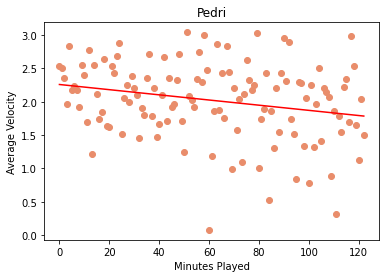

<Figure size 432x288 with 0 Axes>

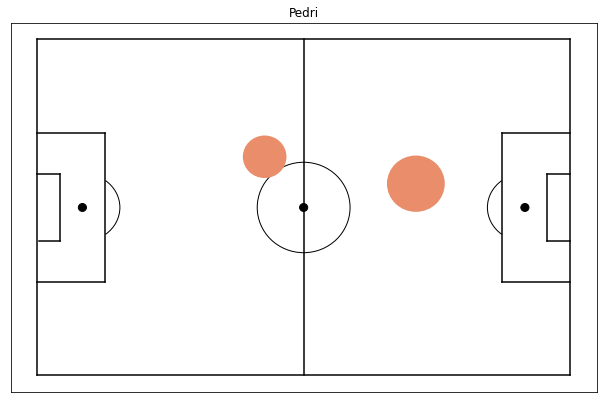

<Figure size 432x288 with 0 Axes>

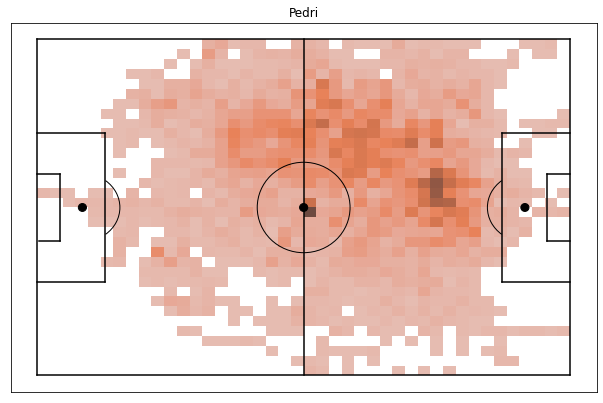

Player Name: Gerard Moreno
Distance Covered: 6544.50 meters


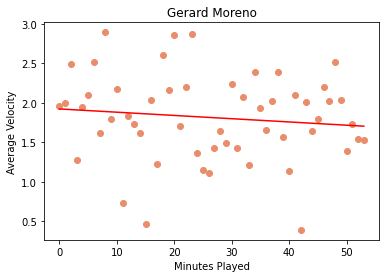

<Figure size 432x288 with 0 Axes>

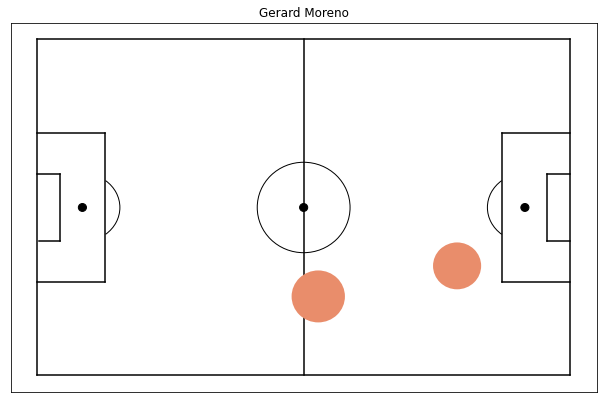

<Figure size 432x288 with 0 Axes>

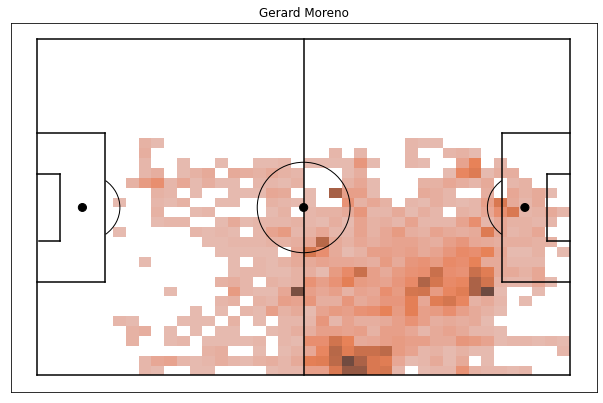

Player Name: Marcos Llorente
Distance Covered: 4624.40 meters


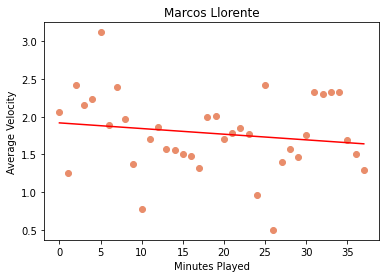

<Figure size 432x288 with 0 Axes>

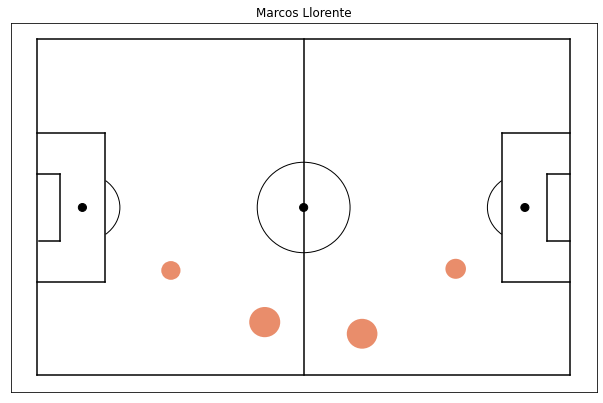

<Figure size 432x288 with 0 Axes>

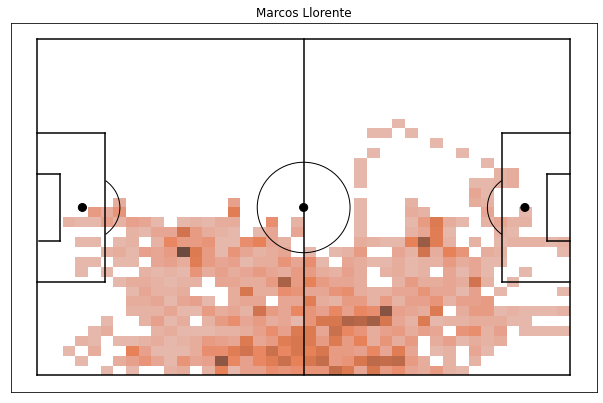

Player Name: César Azpilicueta
Distance Covered: 9768.55 meters


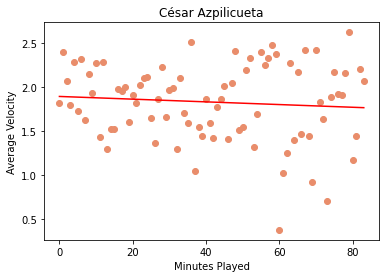

<Figure size 432x288 with 0 Axes>

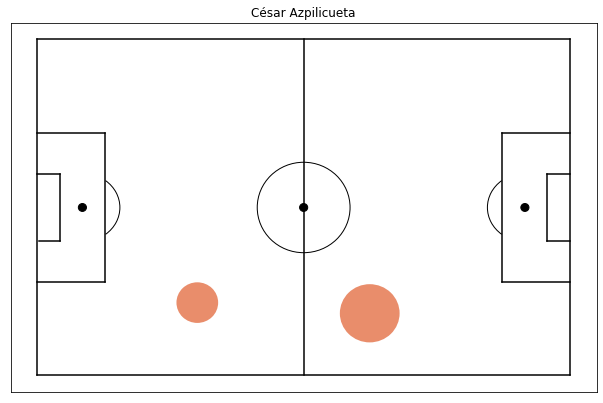

<Figure size 432x288 with 0 Axes>

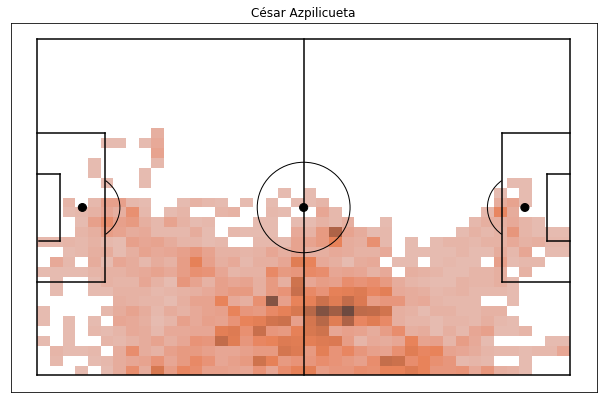

Player Name: Sergio Busquets
Distance Covered: 13515.20 meters


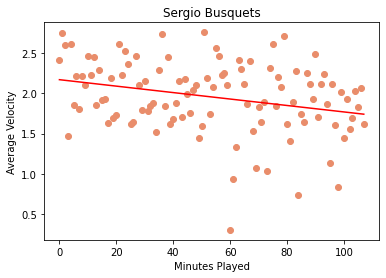

<Figure size 432x288 with 0 Axes>

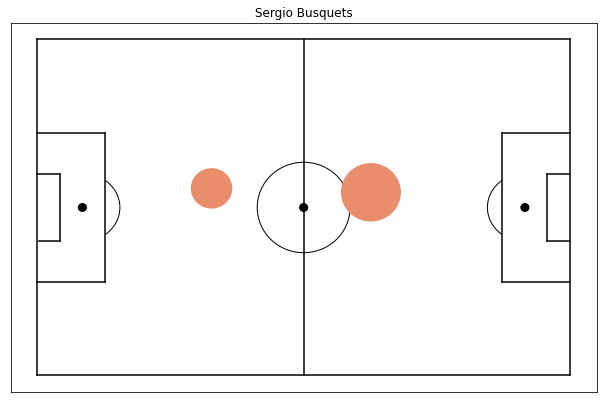

<Figure size 432x288 with 0 Axes>

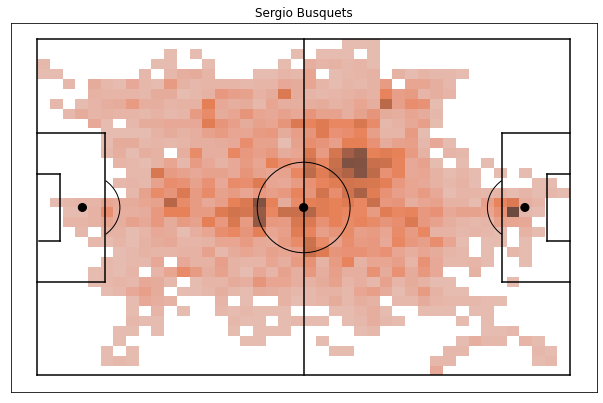

Player Name: Mikel Oyarzabal
Distance Covered: 8043.28 meters


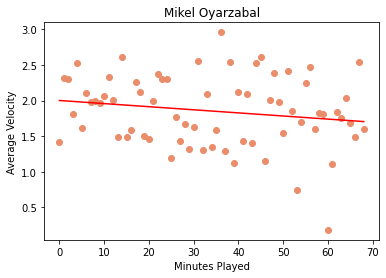

<Figure size 432x288 with 0 Axes>

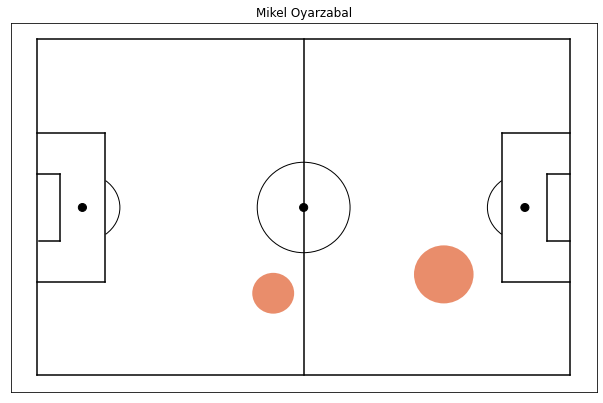

<Figure size 432x288 with 0 Axes>

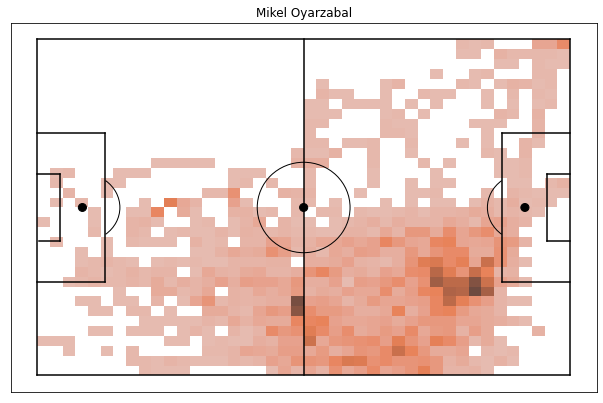

Player Name: Koke
Distance Covered: 9893.88 meters


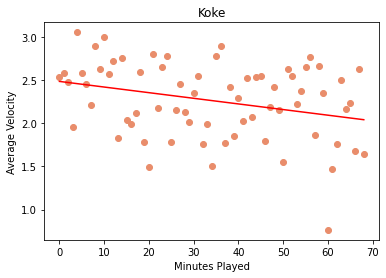

<Figure size 432x288 with 0 Axes>

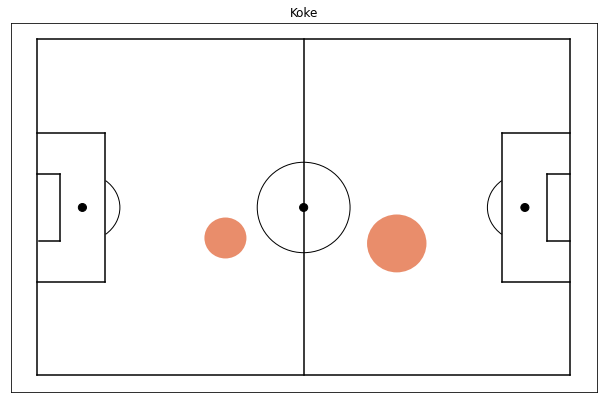

<Figure size 432x288 with 0 Axes>

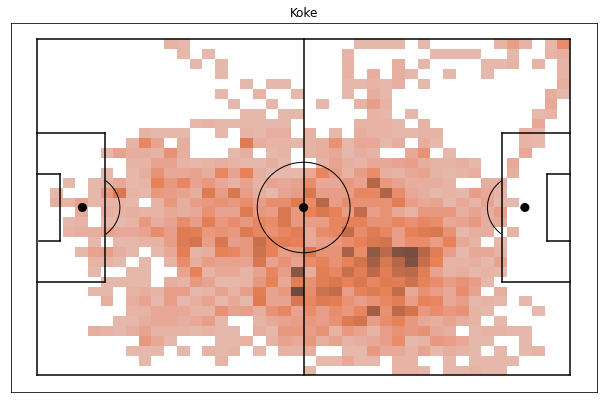

Player Name: Ferran Torres
Distance Covered: 7351.04 meters


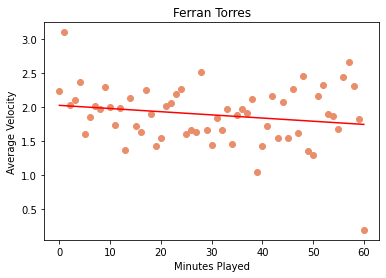

<Figure size 432x288 with 0 Axes>

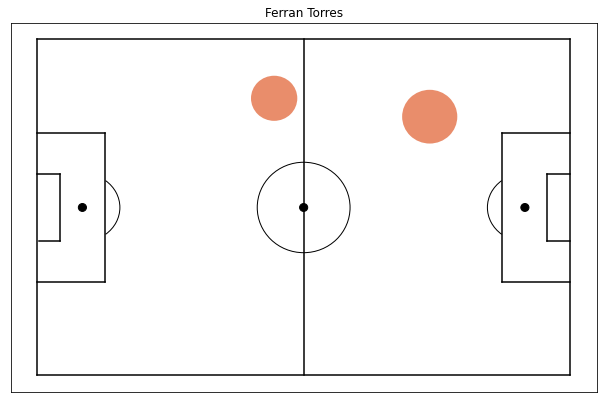

<Figure size 432x288 with 0 Axes>

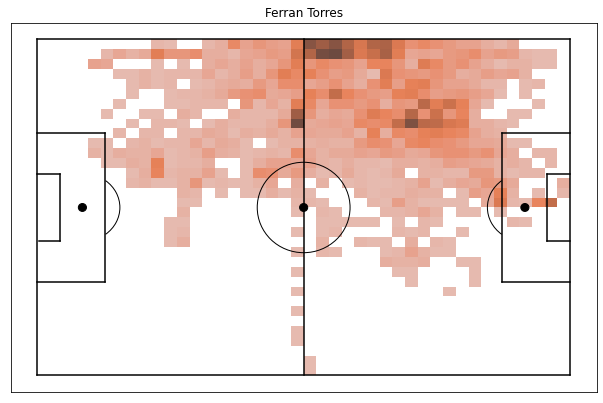

Player Name: Jordi Alba
Distance Covered: 14600.01 meters


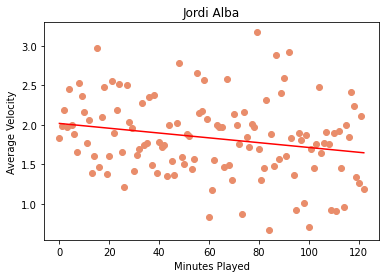

<Figure size 432x288 with 0 Axes>

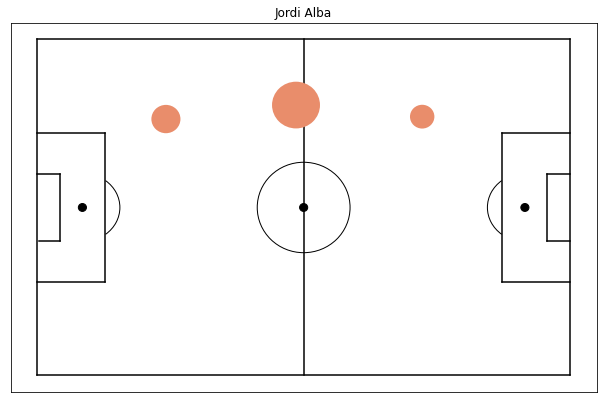

<Figure size 432x288 with 0 Axes>

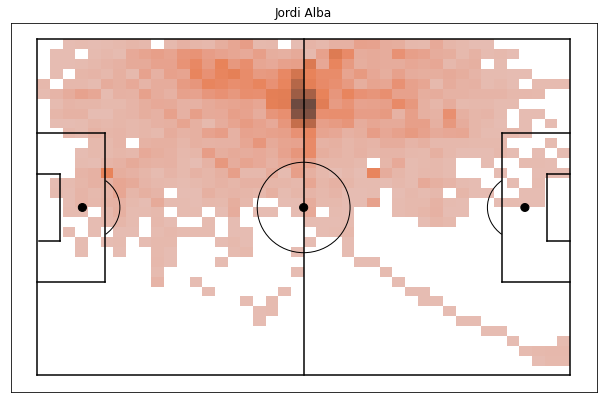

Player Name: Eric García
Distance Covered: 13025.26 meters


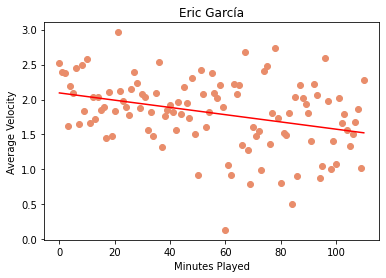

<Figure size 432x288 with 0 Axes>

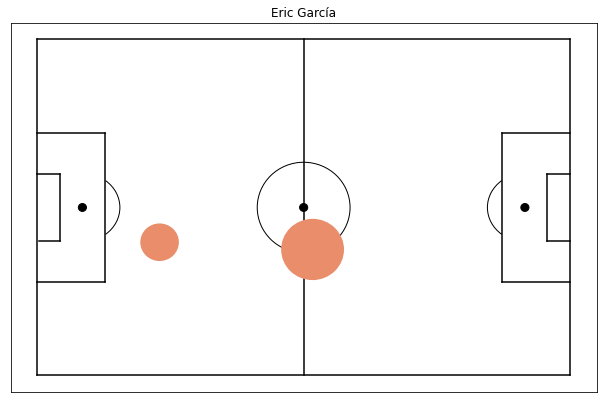

<Figure size 432x288 with 0 Axes>

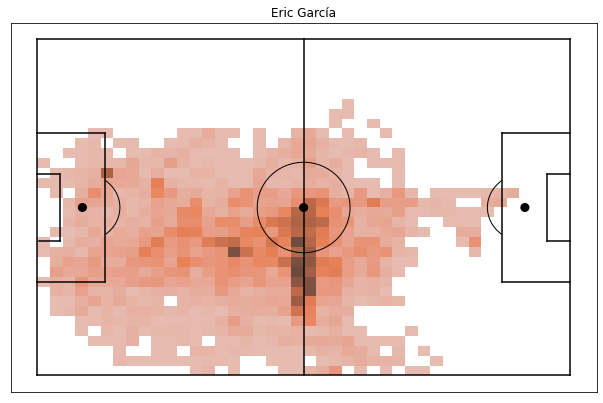

Player Name: Dani Olmo
Distance Covered: 14773.63 meters


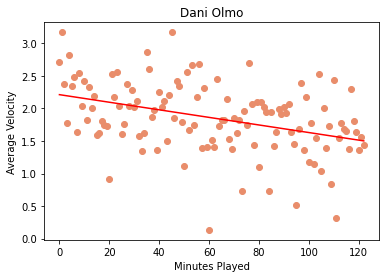

<Figure size 432x288 with 0 Axes>

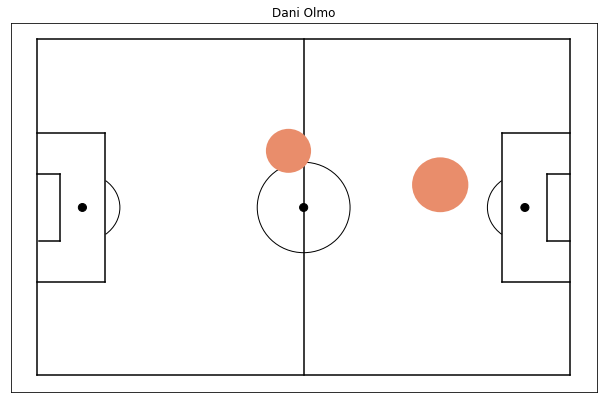

<Figure size 432x288 with 0 Axes>

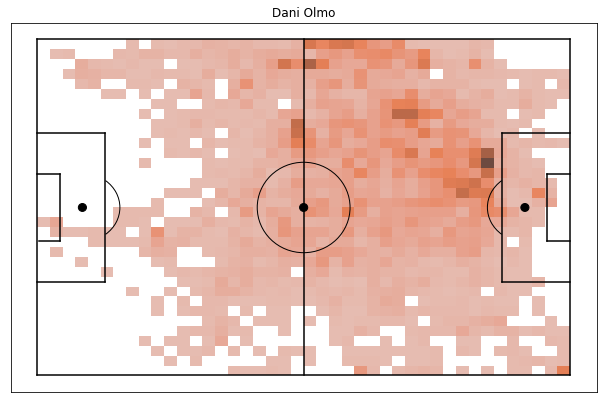

Player Name: Thiago Alcántara
Distance Covered: 1727.18 meters


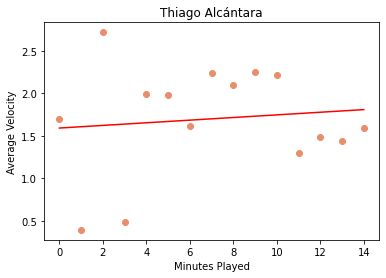

<Figure size 432x288 with 0 Axes>

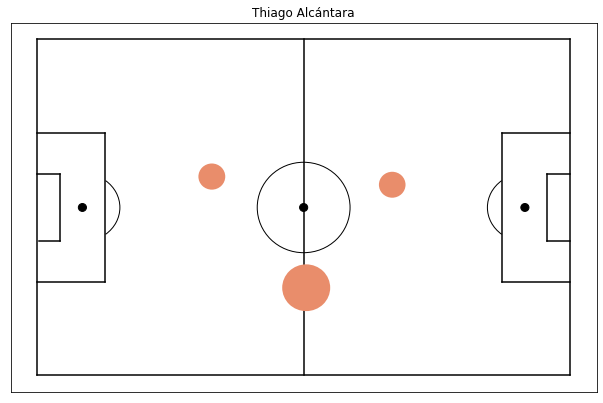

<Figure size 432x288 with 0 Axes>

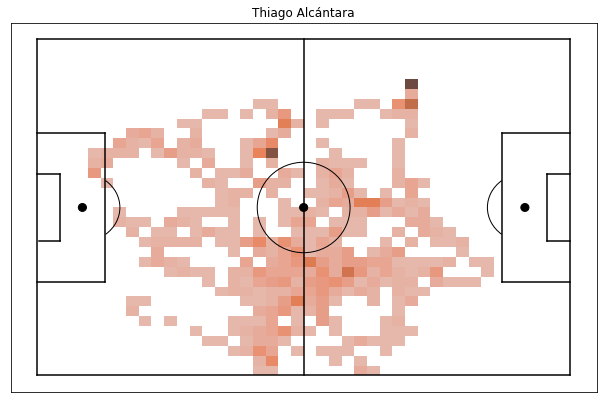

Player Name: Pau Torres
Distance Covered: 1419.22 meters


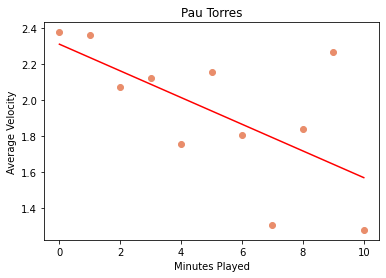

<Figure size 432x288 with 0 Axes>

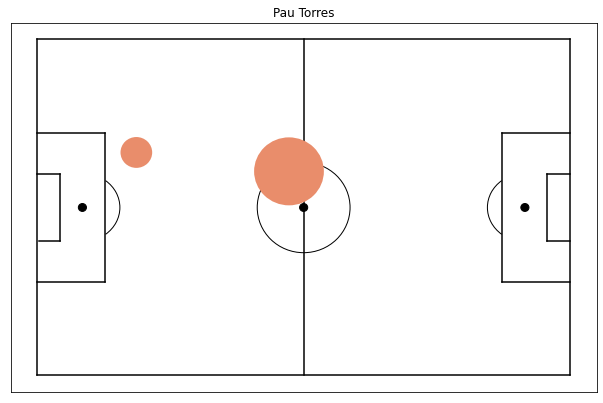

<Figure size 432x288 with 0 Axes>

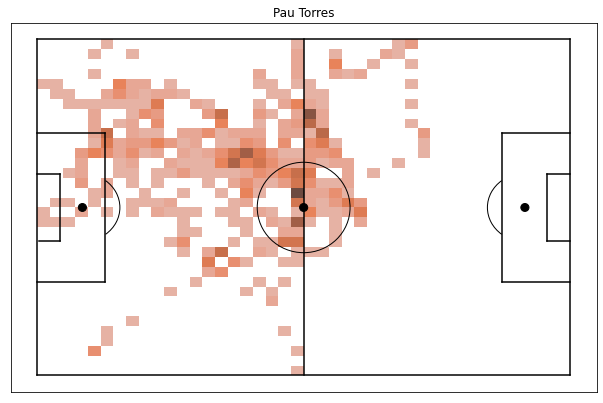

Player Name: Unai Simón
Distance Covered: 8157.54 meters


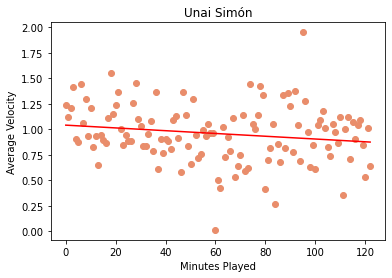

<Figure size 432x288 with 0 Axes>

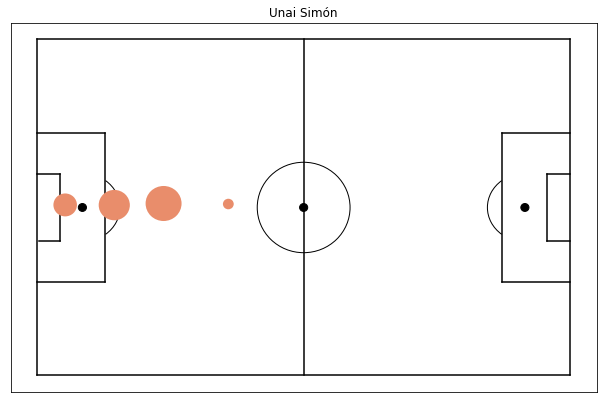

<Figure size 432x288 with 0 Axes>

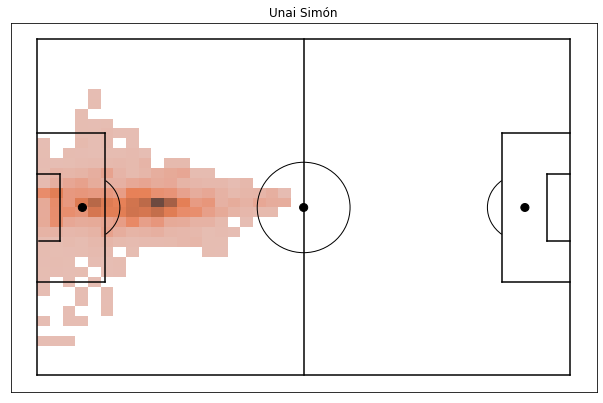

In [43]:
for id in away_ids:
    do_clustering_best_fit_heatmap_for_player(match, id, team_name="spain")